In [1]:
import os, sys
from google.colab import drive
drive.mount("/content/drive")
sys.path.insert(0, "/content/drive/MyDrive/source_data/modules")

Mounted at /content/drive


In [5]:
from pathlib import Path
data_path = Path("/content/drive/MyDrive/source_data")

In [6]:
import skimage
skimage.__version__
# Check that version is 0.18.0

'0.18.0'

## Loading packages and functions

**Understand what the packages below are and do.**

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 2-photon dataset
**Load the tiff stack corresponding to plane 65: *plane065.tif* and load it into a numpy array called *images*. A stack is a file that contains a set of images. It is therefore a three dimensional array (Z,X,Y) or (T,X,Y) depending on whether the different images are from different planes or the same plane at different times. You can also open this stack with ImageJ and browse through it.**

In [8]:
from PIL import Image

img = Image.open(data_path / "plane065.tif")
images = []
for i in range(img.n_frames):
    img.seek(i)
    images.append(np.array(img))


**Use np.shape to query the dimensions of the array *images*. Does this make sense from what you observed in ImageJ?**

In [9]:
np.shape(images)

(1750, 400, 414)

**Generate an anatomy of this plane by summing all the frames. It should look very similar to**

![](https://github.com/vigji/colab-test/blob/main/images/figure1.png?raw=1)

**Do you know where you are in the fish brain?**

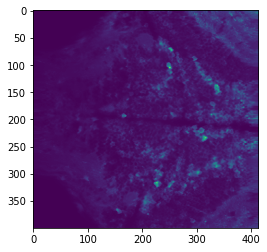

In [10]:
original_anatomy=np.sum(images,0)
plt.figure()
plt.imshow(original_anatomy)

**Now we will use the function** phase_cross_correlation **from skimage. We want to perform sub-pixel corrections, say to 0.1 of a pixel, so make sure you use the** upsample_factor **argument. Save the shifts in the X and Y directions in two arrays called *Xs* and *Ys* and compute also a *total_motion* array (use pythagoras).**

In [11]:
from skimage.registration import phase_cross_correlation
import math
frames=np.array(images)
Xs=np.zeros(np.shape(images)[0])
Ys=np.zeros(np.shape(images)[0])
total_motion=np.zeros(np.shape(images)[0])
for i in range(frames.shape[0]):
    X=phase_cross_correlation(original_anatomy, frames[i,:,:] ,upsample_factor=10, space='real')
    Xs[i]=X[0][0]
    Ys[i]=X[0][1]
    total_motion[i]=math.sqrt(Xs[i]*Xs[i]+Ys[i]*Ys[i])

**Plot the total motion of each frame. Do you think the motion arises from continuous drifts or acute motor events? In a second subplot, plot a scatter plot of the shift for each frame. You can choose to add some jitter so you can visualize dots that are superimposed on one another.**

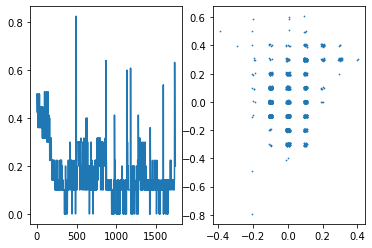

In [12]:
plt.figure()
plt.subplot(1,2,1)
plt.plot(total_motion)
plt.subplot(1,2,2)
plt.scatter(Xs-0.01+0.02*np.random.rand(Xs.shape[0]),Ys-0.01+0.02*np.random.rand(Xs.shape[0]),s=0.5)
plt.show()

## Second order correction of motion artifact

**Correct the individual frames by performing an individual sub-pixel alignment frame by frame. In order to do this use the function** shift **from** scipy.image.

**Use this new corrected stack to generate a new aligned_anatomy. Display the difference image between the original and the aligned anatomies.**

In [13]:
from scipy.ndimage import shift
aligned_frames=np.zeros(frames.shape)
for i in range(frames.shape[0]):
    aligned_frames[i,:,:]=shift(frames[i,:,:], (Xs[i],Ys[i]), output=None, order=3, mode='constant', cval=0.0, prefilter=True)
#   the commented lines below check that the shift was performed in the correct direction    
#   X=phase_cross_correlation(anatomy, frames[i,:,:] ,upsample_factor=10, space='real')
#   print(X)
#   Y=phase_cross_correlation(anatomy, aligned_frames[i,:,:] ,upsample_factor=10, space='real')
#   print(Y)


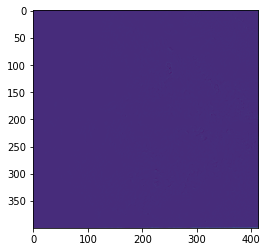

In [14]:
aligned_anatomy=np.sum(aligned_frames,0)
plt.figure()
plt.imshow(original_anatomy-aligned_anatomy)

**Align the ORIGINAL frames to this new aligned_anatomy. Compute the total shift of each frame to this aligned_anatomy and plot this shift on top of the shift you obtained for the first alignment. Why are these different?**

In [15]:
from skimage.registration import phase_cross_correlation
import math
Xs2=np.zeros(np.shape(images)[0])
Ys2=np.zeros(np.shape(images)[0])
total_motion2=np.zeros(np.shape(images)[0])
for i in range(frames.shape[0]):
    X=phase_cross_correlation(aligned_anatomy, frames[i,:,:] ,upsample_factor=10, space='real')
    Xs2[i]=X[0][0]
    Ys2[i]=X[0][1]
    total_motion2[i]=math.sqrt(Xs2[i]*Xs2[i]+Ys2[i]*Ys2[i])


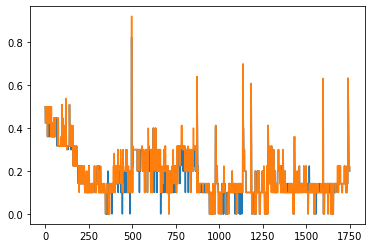

In [16]:
plt.figure()
plt.plot(total_motion)
plt.plot(total_motion2)
plt.show()

**Finally shift the original frames by this new amount to obtain a final stack. You can sum this final stack to obtain a final anatomy.**


In [17]:
from scipy.ndimage import shift
final_frames=np.zeros(frames.shape)
for i in range(frames.shape[0]):
    final_frames[i,:,:]=shift(frames[i,:,:], (Xs2[i],Ys2[i]), output=None, order=3, mode='constant', cval=0.0, prefilter=True)
final_anatomy=np.sum(final_frames,0)


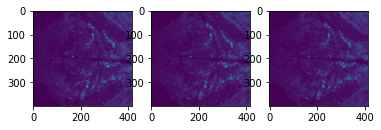

In [18]:
plt.figure()
plt.subplot(1,3,1)
plt.imshow(original_anatomy)
plt.subplot(1,3,2)
plt.imshow(aligned_anatomy)
plt.subplot(1,3,3)
plt.imshow(final_anatomy)

## Creating a correlation map

**Use the function** pearsonr **from** scipy.stats **to compute the correlation between the fluorescence time series of one pixel and the fluorescence time series of its eight surrounding pixels summed (ignore boundary pixels for now).**

**Plot it alongside the anatomy. It should look something like:**

![](https://github.com/vigji/colab-test/blob/main/images/figure2.png?raw=1)

In [19]:
from scipy.stats import pearsonr

correlation_map=np.zeros(final_anatomy.shape)
for i in range(final_anatomy.shape[0]):
    if i>0 and i<(final_anatomy.shape[0]-1):
        for j in range(final_anatomy.shape[1]):
            if j>0 and j<(final_anatomy.shape[1]-1):
                this_pixel=np.squeeze(final_frames[:,i,j])
                surr_pixels=np.squeeze(np.sum(np.sum(np.squeeze(final_frames[:,i-1:i+1,j-1:j+1]),2),1))-this_pixel
                C, _ = pearsonr(this_pixel, surr_pixels)
                correlation_map[i,j]=C
original_correlation_map=np.copy(correlation_map)   



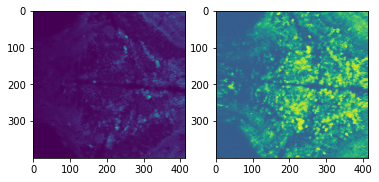

In [20]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(final_anatomy)
plt.subplot(1,2,2)
plt.imshow(correlation_map)
plt.show()

**Plot a histogram of the correlation values. The top left and the bottom left of the image are not within the fish brain. Plot a histogram of the correlation values in this part of the image to gain some insight into the distribution of correlation values of the noise.**

## ROI extraction

**We will now generate a function that extracts ROIs (regions of interest). The function should take 4 inputs: a correlation map, the final stack of aligned frames, a correlation threshold value and a maximum size of an ROI in pixels.**

**The function should:**
- Identify the pixel with the highest correlation value in the correlation map (the ROI seed). Initialize the list of pixels in this ROI with this seed.**
- Compute the individual correlations of the fluorescence time-series in this pixel with its 8 neighbours. A convenient way of idetifying the neighbours of a region is by dilating the reion by one piexl. You can do this by importing **morphology** from skimage and using **morphology.binary_dilation**.
- Add the neighbours whose correlation exceeds the threshold to the ROI.
- Repeat by looking at the neighbouring pixels of the new ROI and computing the correlation of their fluorescence with the total fluorescence of the ROI. Add the pixels to the ROI if they exceed the threshold. 
- Stop the function if no neighbouring pixels exceed the threshold or if the size of the ROI exceeds the maximum size (the last input to the function).
- The function should return the pixels within the ROI, the fluoresence trace of the ROI, the size of the ROI and the correlation map with the values of the pixels in the extracted ROI set to zero.

In [21]:
correlation_map=np.copy(original_correlation_map)

def next_roi(Vcorrelation_map, Vframes, corr_thresh, Vsize):
    
    this_max=np.max(Vcorrelation_map)
    #print(this_max)
    result = np.where(Vcorrelation_map== this_max)
    coords=list(zip(result[0], result[1]))
    I=coords[0][0]
    J=coords[0][1]
    this_roi_trace=np.squeeze(Vframes[:,I,J])
    this_roi=np.zeros(Vcorrelation_map.shape)
    this_roi[I,J]=1;
    this_correlation_map=np.copy(Vcorrelation_map)
    this_correlation_map[I,J]=0;
    from skimage import morphology

    added=1
    while (np.sum(np.sum(this_roi,1),0)<Vsize and added==1):
        added=0
        dilated=morphology.binary_dilation(this_roi, np.ones((3,3))).astype(np.uint8)
        new_pixels=dilated-this_roi
        result = np.where(new_pixels == 1)
        coords=list(zip(result[0], result[1]))
        coords2=np.asarray(coords, dtype=np.int32)
        for a in range(coords2.shape[0]):
            I=coords2[a][0]
            J=coords2[a][1]
            if not(this_correlation_map[I,J]==0):
                Y=np.squeeze(Vframes[:,I,J])
                C, _ = pearsonr(this_roi_trace, Y)
                if C>corr_thresh:
                    this_roi[I,J]=1
                    this_correlation_map[I,J]=0
                    this_roi_trace=this_roi_trace+Y
                    added=1

    return this_roi, this_roi_trace, np.sum(np.sum(this_roi,1),0), this_correlation_map



**Use the function you have written to extract 200 ROIs within the plane. Use a correlation threshold value of 0.8 and a maximum ROI size of 200 pixels.**

**Plot a figure with three subplots. The first one should be an image of the fluorescence of the 200 ROIs. Make sure that you plot the normalized or zscored fluorescence for each ROI to be able to compare them. Import** zscore **from** scipy.stats **to do this. The second one a map showing the ROIs extraces and the thirs one the original correlation map with the correlation of the extracted ROIs set to zero. It should look something like this:**

![](https://github.com/vigji/colab-test/blob/main/images/figure3.png?raw=1)

In [22]:
Nrois=200
all_traces=np.zeros((Nrois,aligned_frames.shape[0]))
all_rois=np.zeros(original_correlation_map.shape)
used_pixels=np.zeros(original_correlation_map.shape)

for i in range(Nrois):
    this_roi3,this_roi_trace,N,this_correlation_map=next_roi(correlation_map, aligned_frames, 0.8,200)
    all_traces[i,:]=this_roi_trace
    all_rois=all_rois+(i+1)*this_roi3
    used_pixels=used_pixels+this_roi3
    correlation_map[all_rois>0]=0
    


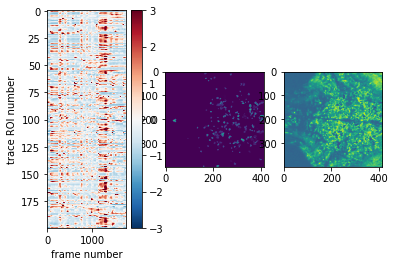

In [23]:
from scipy.stats import zscore

fig,(ax1,ax2,ax3)= plt.subplots(1,3)

img=ax1.imshow(zscore(all_traces, 1), aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r")
ax1.set_ylabel("trace ROI number")
ax1.set_xlabel("frame number")
fig.colorbar(img,ax=ax1)
ax2.imshow(all_rois)
ax3.imshow(correlation_map)
plt.show()



**Save the array with the traces as a numpy data file.**

In [24]:
np.save("traces.npy", all_traces)

In [25]:
all_traces=np.load("traces.npy")

In [26]:
import pandas as pd

expt_time = pd.read_csv(data_path / "time.csv")
coherences = pd.read_csv(data_path / "stimulus.csv")
behavior = pd.read_csv(data_path / "behavior.csv")


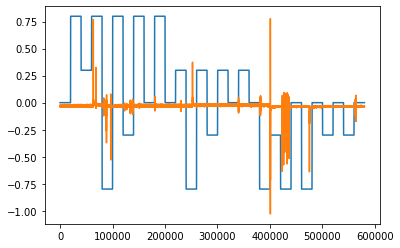

In [27]:
stimulus=coherences["Coherence"]
stimulus=np.array(stimulus)
stimulus[stimulus<-5]=0

time=expt_time["Time"]
time=np.array(time)

beh_65=behavior["Plane65"]
beh_65=np.array(beh_65/np.max(np.absolute(beh_65)))
beh_65[np.argwhere(np.isnan(beh_65))]=0

plt.figure()
plt.plot(time,stimulus)
plt.plot(time,beh_65-0.03)

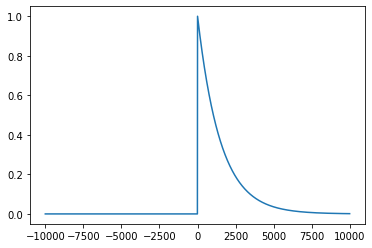

In [28]:
import math
exp_t=np.zeros((2000))
exp_k=np.zeros((2000))
for i in range(2000):
    exp_t[i]=10*i-10000
    exp_k[i]=math.exp(-(10*i-10000)/1500)
exp_k[exp_t<0]=0
plt.figure()
plt.plot(exp_t,exp_k)
plt.show()

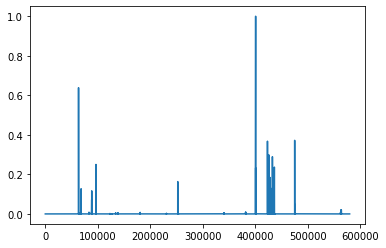

In [29]:
vig=beh_65*beh_65
plt.figure()
plt.plot(time,vig)
plt.show()

## Here we define motor regressors 

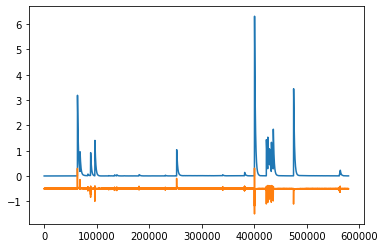

In [30]:
num_regressors=4
Reg=np.empty((4,vig.shape[0]))

Reg[0,:]=np.convolve(vig,exp_k,'same')

plt.figure()
plt.plot(time,Reg[0,:])
plt.plot(time,beh_65-0.5)
plt.show()



## Here we define stimulus regressors

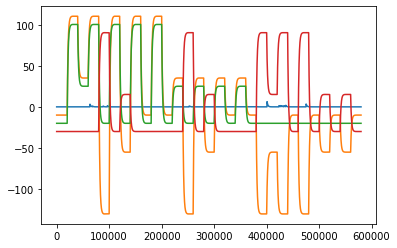

In [31]:
stimulus[np.argwhere(np.isnan(stimulus))]=0
stimulusP=np.copy(stimulus)
stimulusP[stimulusP<0]=0;
stimulusN=np.copy(stimulus)
stimulusN[stimulusN>0]=0;
stimulusN=-stimulusN

Reg[1,:]=np.convolve(stimulus,exp_k,'same')
Reg[2,:]=np.convolve(stimulusP,exp_k,'same')
Reg[3,:]=np.convolve(stimulusN,exp_k,'same')

plt.figure()
for j in range(0,4):
    plt.plot(time,Reg[j,:]-10*j)
plt.show()

In [32]:
Reg[0,:]

array([0.00000000e+00, 0.00000000e+00, 1.61782092e-06, ...,
       3.67897152e-03, 3.68579446e-03, 3.67382042e-03])

In [33]:
plt.close('all')

In [34]:
imaging_times=np.zeros(1736);
for i in range(1736):
    imaging_times[i]=i*334;

In [35]:
num_regressors=4

**There are 1750 imaging frames, taken every 334 ms. The behavior was recorded until time 580s, which corresponds to the time of the 1736.5 imaging frame.**

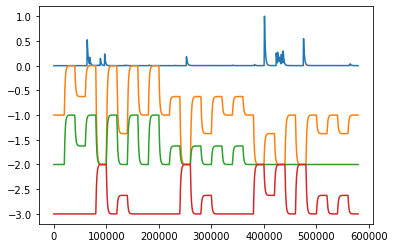

In [36]:
int_Reg=np.zeros([num_regressors,1736])
from scipy import interpolate

plt.figure()
for j in range(num_regressors):
    f=interpolate.interp1d(time,Reg[j,:])
    int_Reg[j,:]=f(imaging_times)
    int_Reg[j,:]=int_Reg[j,:]/(np.max(np.abs(int_Reg[j,:])))
    plt.plot(imaging_times,int_Reg[j,:]-j)


    

**We compute the correlation of each ROI with each of the rgressors we have defined and we save these values into a matrix called all_correlations(num_regressors,number_ROIs)**

In [37]:
from scipy.stats import pearsonr
all_correlations=np.zeros([num_regressors,200])
for k in range(num_regressors):
    for j in range(200):
        C,_=pearsonr(int_Reg[k,:],all_traces[j,0:1736])
        all_correlations[k,j]=C
    

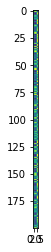

In [38]:
plt.figure()
plt.imshow(np.transpose(all_correlations))
plt.show()

### We can now plot the ROI that has the highest correlation with each of the four regressors

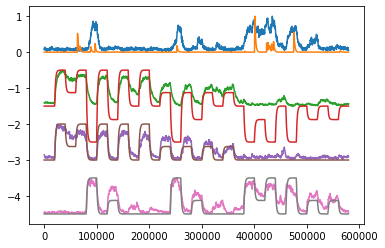

In [39]:
plt.figure()
for k in range(4):
    id=np.argmax(all_correlations[k,:])
    Y=all_traces[id,0:1736]
    Y=Y-np.min(Y)
    Y=Y/np.max(Y)
    plt.plot(imaging_times,Y-1.5*k)
    plt.plot(imaging_times,int_Reg[k,:]-1.5*k)
plt.show()

### ... and the ROI that has the lowest correlation with each of the four regressors

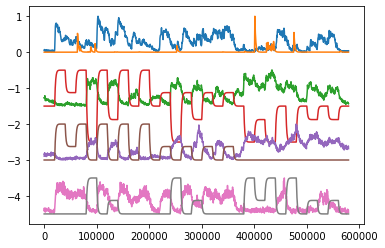

In [40]:
plt.figure()
for k in range(4):
    id=np.argmin(all_correlations[k,:])
    Y=all_traces[id,0:1736]
    Y=Y-np.min(Y)
    Y=Y/np.max(Y)
    plt.plot(imaging_times,Y-1.5*k)
    plt.plot(imaging_times,int_Reg[k,:]-1.5*k)
plt.show()

# Population Analysis



## Principal Component Analysis

Let us start by doing some principal component analysis to investigate the activity traces that describe most of the variance. We can start asking for the first 10 principal components (PCs). We feed the normalized fluorescence traces. We also plot the variance explained by each principal component. 

In [41]:
from sklearn.decomposition import PCA
from scipy.stats import zscore

pca=PCA(n_components=10)
principalComponents=pca.fit_transform(zscore(all_traces,1))

In [42]:
pca.explained_variance_ratio_

array([0.40869205, 0.1137854 , 0.09299108, 0.04841201, 0.03935416,
       0.02709126, 0.02300525, 0.02076977, 0.01920987, 0.01505079])

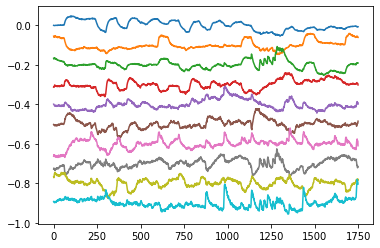

In [43]:
plt.figure()
for i in range(10):
    plt.plot(pca.components_[i]-0.1*i)
plt.show()

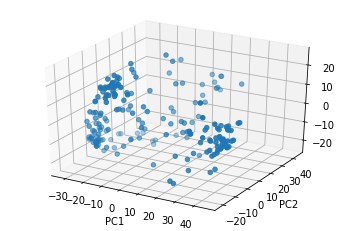

In [44]:
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter(principalComponents[:,0],principalComponents[:,1],principalComponents[:,2])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Clustering Exercise

**Cluster the normalized fluorescence traces into clusters using k-means. Try between 2 and 10 clusters. For each number of clusters, plot the total remaining unexplained variance (the sum of the distances squared between each point and its cluster centroid. How many clusters do you think there are?**

**Now cluster the correlation values into clusters using k-means. Again, try between 2 and 10 clusters. For each number of clusters, plot the total remaining unexplained variance (the sum of the distances squared between each point and its cluster centroid. How many clusters do you think there are? Do the clusters computer in two different ways above agree?**

**We now cluster using the first 10 PC coefficients. Just as an example we cluster into 3 and 6 clusters.** 

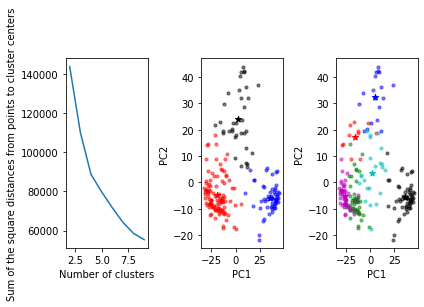

In [45]:
from sklearn.cluster import KMeans

distances=np.zeros((10,1))

for j in range(2,10,1):
  kmeans=KMeans(j,n_init=30).fit(principalComponents[:,0:9])
  Y=kmeans.labels_
  distances[j]=kmeans.inertia_

fig=plt.figure()
plt.subplot(131)
plt.plot(np.asarray(range(2,10,1)),distances[2:10])
plt.xlabel('Number of clusters')
plt.ylabel('Sum of the square distances from points to cluster centers')

kmeans=KMeans(3,n_init=30).fit(principalComponents[:,0:9])
Y=kmeans.labels_
Y3=Y
Z3=kmeans.cluster_centers_

plt.subplot(132)
for i in range(3):
  X=principalComponents[:,0:9]
  K=X[np.squeeze(Y==i),:]
  if i==0:
    plt.scatter(K[:,0],K[:,1],10,'r',alpha=0.5)
    plt.scatter(Z3[i,0],Z3[i,1],40,'r',marker='*')
  if i==1:
    plt.scatter(K[:,0],K[:,1],10,'b',alpha=0.5)
    plt.scatter(Z3[i,0],Z3[i,1],40,'b',marker='*')
  if i==2:
    plt.scatter(K[:,0],K[:,1],10,'k',alpha=0.5)
    plt.scatter(Z3[i,0],Z3[i,1],40,'k',marker='*')
    
plt.xlabel('PC1')
plt.ylabel('PC2')

kmeans=KMeans(6,n_init=30).fit(principalComponents[:,0:9])
Y=kmeans.labels_
Z6=kmeans.cluster_centers_
Y6=Y
Z=Z6

plt.subplot(133)
for i in range(6):
  X=principalComponents[:,0:9]
  K=X[np.squeeze(Y==i),:]
  if i==0:
    plt.scatter(K[:,0],K[:,1],10,'r',alpha=0.5)
    plt.scatter(Z[i,0],Z[i,1],40,'r',marker='*')
  if i==1:
    plt.scatter(K[:,0],K[:,1],10,'b',alpha=0.5)
    plt.scatter(Z[i,0],Z[i,1],40,'b',marker='*')
  if i==2:
    plt.scatter(K[:,0],K[:,1],10,'k',alpha=0.5)
    plt.scatter(Z[i,0],Z[i,1],40,'k',marker='*')
  if i==3:
    plt.scatter(K[:,0],K[:,1],10,'g',alpha=0.5)
    plt.scatter(Z[i,0],Z[i,1],40,'g',marker='*')
  if i==4:
    plt.scatter(K[:,0],K[:,1],10,'c',alpha=0.5)
    plt.scatter(Z[i,0],Z[i,1],40,'c',marker='*')
  if i==5:
    plt.scatter(K[:,0],K[:,1],10,'m',alpha=0.5)
    plt.scatter(Z[i,0],Z[i,1],40,'m',marker='*')
    
plt.xlabel('PC1')
plt.ylabel('PC2')
fig.tight_layout()
plt.show()

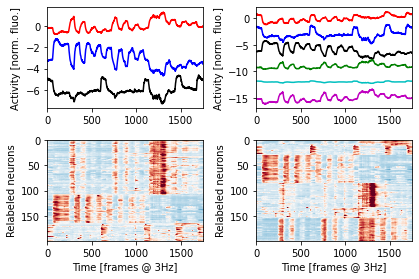

In [46]:
fig,((a0,a1),(a2,a3))=plt.subplots(2,2)
ztraces=zscore(all_traces,1)

a0.plot(Z3[0,0]*pca.components_[0]+Z3[0,1]*pca.components_[1],'r')
a0.plot(Z3[1,0]*pca.components_[0]+Z3[1,1]*pca.components_[1]-3,'b')
a0.plot(Z3[2,0]*pca.components_[0]+Z3[2,1]*pca.components_[1]-6,'k')
a0.set_ylabel('Activity [norm. fluo.]')
a0.set_xlim(0,ztraces.shape[1])

a1.plot(Z6[0,0]*pca.components_[0]+Z6[0,1]*pca.components_[1],'r')
a1.plot(Z6[1,0]*pca.components_[0]+Z6[1,1]*pca.components_[1]-3,'b')
a1.plot(Z6[2,0]*pca.components_[0]+Z6[2,1]*pca.components_[1]-6,'k')
a1.plot(Z6[3,0]*pca.components_[0]+Z6[3,1]*pca.components_[1]-9,'g')
a1.plot(Z6[4,0]*pca.components_[0]+Z6[4,1]*pca.components_[1]-12,'c')
a1.plot(Z6[5,0]*pca.components_[0]+Z6[5,1]*pca.components_[1]-15,'m')
a1.set_ylabel('Activity [norm. fluo.]')
a1.set_xlim(0,ztraces.shape[1])

Zv1=ztraces[Y3==0,:]
Zv1b=np.zeros((1,ztraces.shape[1]))
Zv2=ztraces[Y3==1,:]
Zv3=ztraces[Y3==2,:]

traces_stacked=np.concatenate((Zv1,Zv2,Zv3),axis=0)

a2.imshow(traces_stacked, aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r")
a2.set_xlabel('Time [frames @ 3Hz]')
a2.set_ylabel('Relabeled neurons')

Zv1=ztraces[Y6==0,:]
Zv2=ztraces[Y6==1,:]
Zv3=ztraces[Y6==2,:]
Zv4=ztraces[Y6==3,:]
Zv5=ztraces[Y6==4,:]
Zv6=ztraces[Y6==5,:]

traces_stacked=np.concatenate((Zv1,Zv2,Zv3,Zv4,Zv5,Zv6),axis=0)

a3.imshow(traces_stacked, aspect="auto", vmin=-3, vmax=3, cmap="RdBu_r")
a3.set_xlabel('Time [frames @ 3Hz]')
a3.set_ylabel('Relabeled neurons')
fig.tight_layout()
plt.show()

### State space analysis

**We now look at how the neurons behave in time. We perform PCA but now we seek the sets of neurons that explain most of the variance, and how these sets of neurons are activated in time.**

In [47]:
pca=PCA(n_components=3)
principalComponents=pca.fit_transform(np.transpose(zscore(all_traces,1)))

In [48]:
pca.explained_variance_ratio_

array([0.39819508, 0.15238317, 0.08919082])

**We color code the trajectories (in time) by the stimulus that was being shown. We plot a 3d scatter plot and 3 2d scatter plots to visualize things well. What are the colors?**

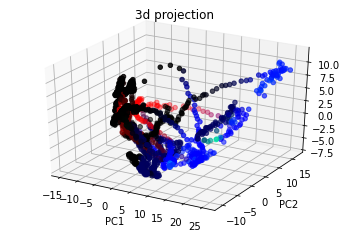

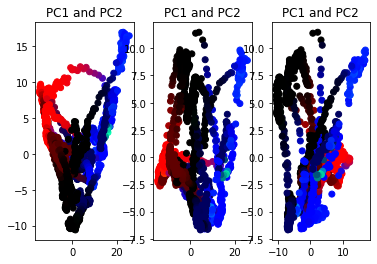

In [49]:
col=np.zeros([1750,3])
for i in range(1736):
    col[i,0]=int_Reg[2,i];
    col[i,2]=int_Reg[3,i];
    col[i,1]=int_Reg[0,i];
    
fig2=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter(principalComponents[:,0],principalComponents[:,1],principalComponents[:,2],c=col[:,:])
ax.set_title("3d projection")
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

fig,((ax1,ax2,ax3))= plt.subplots(1,3)
ax1.scatter(principalComponents[:,0],principalComponents[:,1],c=col[:,:])
ax1.set_title("PC1 and PC2")
ax2.scatter(principalComponents[:,0],principalComponents[:,2],c=col[:,:])
ax2.set_title("PC1 and PC2")
ax3.scatter(principalComponents[:,1],principalComponents[:,2],c=col[:,:])
ax3.set_title("PC1 and PC2")
plt.show()




In [50]:
pca=PCA(n_components=3)
principalComponents=pca.fit_transform((zscore(all_traces,1)))